In [11]:
import os
import sys
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import pickle
import matplotlib.pyplot as plt
import numpy as np
from typing import Sequence, List, Dict, Any, Tuple, Optional
from tqdm import tqdm
from functools import partial

import e3nn_jax as e3nn
import plotly.graph_objects as go
from itertools import permutations
import chex


# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from utils.plotters import visualize_geometry, colorplot, visualize_signal, compare_geometries
from utils.geometries import trigonal_plane, tetrahedron, octahedron, icosahedron, dodecahedron
from utils.alignment import sample_uniform_quaternion, align_signals, find_best_random_quaternion, rotate_points_quaternion, stack_points, point_distance, spherical_harmonic_distance, stack_points, choose_best_quaternion, evenly_distributed_quaternions, quaternion_rotation_distance, spherical_grid_distance
import spectra
from spectra import sum_of_diracs, powerspectrum, bispectrum, trispectrum

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)


def radius_mae(arr1, arr2):
    """
    Compute the minimum average of the absolute differences between two arrays
    by trying all possible permutations of the second array.
    
    Parameters:
    arr1 (numpy.ndarray): First 1D numpy array
    arr2 (numpy.ndarray): Second 1D numpy array of the same length as arr1
    
    Returns:
    float: Minimum average absolute difference
    tuple: The permutation of arr2 that gives the minimum difference
    """

    arr1_norms = jnp.linalg.norm(arr1, axis=1)
    arr2_norms = jnp.linalg.norm(arr2, axis=1)

    if len(arr1_norms) != len(arr2_norms):
        return jnp.nan
    
    if len(arr1) == 0:
        return 0, []
    
    min_avg = float('inf')
    best_perm = None
    
    # Generate all permutations of arr2
    for perm in permutations(arr2_norms):
        perm_arr = jnp.array(perm)
        # Calculate absolute differences
        abs_diff = jnp.abs(arr1_norms - perm_arr)
        # Calculate mean of absolute differences
        avg_diff = jnp.mean(abs_diff)
        
        # Update minimum if current permutation gives better result
        if avg_diff < min_avg:
            min_avg = avg_diff
            best_perm = perm
    
    return float(min_avg)


def invert(true_spectrum, spectrum_function, lmax, mask_index=None, initial_points=None, n_points=20, learning_rate=1e-2, 
                     seed=0, num_iterations=10000, patience=1000):
    """
    Inverts either the power spectrum or bispectrum to a signal with adaptive learning rate.
    Returns the final signal and history of points saved every 100 iterations.
    
    Args:
        true_spectrum: Target spectrum to match
        spectrum_function: Either powerspectrum or bispectrum
        lmax: Maximum degree for spherical harmonics
        mask_index: Index of the bispectrum component to mask in loss calculation (None to use all components)
        initial_points: Initial point locations (None for random initialization)
        learning_rate: Initial learning rate
        seed: Random seed for initialization
        num_iterations: Maximum number of iterations
        
    Returns:
        tuple: (best_points, points_history, losses_history)
            - best_points: Points that achieved the lowest loss
            - points_history: Dictionary with iteration numbers as keys and points at those iterations as values
            - losses_history: Dictionary with iteration numbers as keys and loss values at those iterations
    """
    def loss(
        params: optax.Params, true_spectrum: chex.Array
    ) -> chex.Array:
        """Computes the loss corresponding to the current parameters."""
        predicted_signal = sum_of_diracs(params["points"], lmax)
        pred_spectrum = spectrum_function(predicted_signal)
        
        if mask_index is not None:
            # Create a mask that is True for all indices except the one to be masked
            mask = jnp.ones_like(true_spectrum, dtype=bool)
            mask = mask.at[mask_index].set(False)
            
            # Apply the mask to both true and predicted spectra
            masked_true = true_spectrum * mask
            masked_pred = pred_spectrum * mask
            
            # Compute L1 loss only on unmasked elements
            return jnp.abs(masked_true - masked_pred).mean()
            # return optax.l2_loss(masked_true, masked_pred).mean()
        else:
            # Original behavior when no masking is requested
            return jnp.abs(true_spectrum - pred_spectrum).mean()
            # return optax.l2_loss(true_spectrum, pred_spectrum).mean()

    def fit(
        params: optax.Params,
        learning_rate: float,
        true_spectrum: chex.Array,
        max_iter: int = num_iterations,
    ):
        # Create optimizer with fixed learning rate
        optimizer = optax.adam(learning_rate=learning_rate)        
        opt_state = optimizer.init(params)
        
        # Track optimization progress
        min_loss = float('inf')
        no_improvement_count = 0
        
        # Save best parameters
        best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
        
        # Initialize points history dictionary
        points_history = {}
        losses_history = {}
        
        # Pure function to update parameters - JIT compatible
        @jax.jit
        def step(params, opt_state, true_spectrum, step_idx):
            loss_value, grads = jax.value_and_grad(loss)(
                params, true_spectrum
            )
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss_value
        
        for iter in range(max_iter):
            # Pass iteration count to the step function
            params, opt_state, loss_value = step(
                params, opt_state, true_spectrum, iter
            )
            
            # Save points every iterations
            if iter % 100 == 0:
                # We need to convert JAX arrays to numpy arrays for the history
                points_history[iter] = jax.device_get(params["points"])
                losses_history[iter] = jax.device_get(loss_value)
                # print(f"step {iter}, loss: {loss_value}")
            
            # Check if loss decreased
            if loss_value < min_loss:
                min_loss = loss_value
                no_improvement_count = 0
                # Save the best parameters
                best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
            else:
                no_improvement_count += 1
                
            # Early stopping if no improvement for patience iterations
            if no_improvement_count >= patience:
                # print(f"Stopping early at step {iter}: no improvement for {patience} iterations")
                # Save the final points before breaking
                if iter % 100 != 0:  # Only if we haven't just saved them
                    points_history[iter] = jax.device_get(params["points"])
                    losses_history[iter] = jax.device_get(loss_value)
                break

        # Return the best parameters found during optimization
        # print(f"Final best loss: {min_loss}")
        return best_params, points_history, losses_history
    
    if initial_points is None and n_points is None:
        rng = jax.random.PRNGKey(seed)
        initial_points = dodecahedron + 0.1 * jax.random.normal(rng, (dodecahedron.shape[0], 3))
    elif initial_points is None and n_points is not None:
        rng = jax.random.PRNGKey(seed)
        initial_points = jax.random.normal(rng, (n_points, 3))
    init_params = {"points": initial_points}
    
    # Create optimizer with fixed learning rate
    final_params, points_history, losses_history = fit(init_params, learning_rate, true_spectrum)

    predicted_points = final_params["points"]
    predicted_geometry = stack_points(predicted_points)
    
    # Return both the best points and the history of points
    return predicted_geometry, points_history, losses_history

In [12]:
def multi_stage_inversion(true_bispectrum, lmax, n_points=10):
    """
    Performs multi-stage inversion of a bispectrum with different learning rates.
    
    Args:
        true_bispectrum: Target bispectrum to match
        lmax: Maximum degree for spherical harmonics
        n_points: Number of points to use for initial inversion
        
    Returns:
        jnp.ndarray: The predicted geometry with the lowest loss
    """
    # Define a list of learning rates to use in sequence
    learning_rates = [1e-2, 2e-4]
    
    # Run the initial inversion
    predicted_points, _, losses_history = invert(true_bispectrum, bispectrum, lmax, n_points=n_points, learning_rate=learning_rates[0], patience=10000)
    
    # Stack points after first inversion
    stacked_points = stack_points(predicted_points)
    current_points = stacked_points
    
    # Track the best points and lowest loss
    best_loss = float('inf')
    best_points = None
    
    # Store the initial result if it's the best so far
    min_loss_key = min(losses_history, key=losses_history.get)
    if losses_history[min_loss_key] < best_loss:
        best_loss = losses_history[min_loss_key]
        best_points = predicted_points
    
    # Run subsequent inversion with different learning rate
    predicted_points, _, losses_history = invert(true_bispectrum, bispectrum, lmax, initial_points=current_points, learning_rate=learning_rates[1], patience=10000)
    current_points = predicted_points
    
    # Check if this phase produced a better result
    min_loss_key = min(losses_history, key=losses_history.get)
    if losses_history[min_loss_key] < best_loss:
        best_loss = losses_history[min_loss_key]
        best_points = predicted_points
    
    return best_points

In [3]:
with open('../data/qm9_local_envs.pkl', 'rb') as f:
    local_envs = pickle.load(f)

local_envs = local_envs[:100000]
print(f"Number of local environments: {len(local_envs)}")

Number of local environments: 100000


In [4]:
lmax = 5
bispectra = []
for local_env in tqdm(local_envs):
    true_geometry = jnp.array(local_env)
    true_signal = sum_of_diracs(true_geometry, lmax)
    true_bispectrum = bispectrum(true_signal)
    bispectra.append(true_bispectrum)

100%|██████████| 100000/100000 [03:50<00:00, 433.39it/s]


In [13]:
#--------------------------------------------------------------------------------
# Model Definitions
#--------------------------------------------------------------------------------

class Encoder(nn.Module):
    latent_dim: int
    hidden_dims: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        for hidden_dim in self.hidden_dims:
            x = nn.Dense(hidden_dim)(x)
            x = nn.relu(x)
        
        x = nn.Dense(self.latent_dim)(x)
        return x

class Decoder(nn.Module):
    output_dim: int
    hidden_dims: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        for hidden_dim in self.hidden_dims[::-1]:  # Reverse the hidden dimensions
            x = nn.Dense(hidden_dim)(x)
            x = nn.relu(x)
        
        x = nn.Dense(self.output_dim)(x)
        return x

class Autoencoder(nn.Module):
    latent_dim: int
    hidden_dims: Sequence[int]
    output_dim: int
    
    def setup(self):
        self.encoder = Encoder(self.latent_dim, self.hidden_dims)
        self.decoder = Decoder(self.output_dim, self.hidden_dims)
    
    def __call__(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

#--------------------------------------------------------------------------------
# Data Handling Functions
#--------------------------------------------------------------------------------

def data_loader(data, batch_size, shuffle=True, seed=0):
    """
    Create a simple data loader.
    
    Args:
        data: The dataset to load
        batch_size: Size of each batch
        shuffle: Whether to shuffle the data
        seed: Random seed for shuffling
    
    Returns:
        Generator yielding batches of data
    """
    data_size = len(data)
    indices = jnp.arange(data_size)
    
    if shuffle:
        rng = jax.random.PRNGKey(seed)
        indices = jax.random.permutation(rng, indices)
    
    num_complete_batches = data_size // batch_size
    
    for i in range(num_complete_batches):
        batch_indices = indices[i * batch_size:(i + 1) * batch_size]
        yield data[batch_indices]
    
    # Return any remaining data as the final batch
    if data_size % batch_size != 0:
        final_indices = indices[num_complete_batches * batch_size:]
        yield data[final_indices]

def split_data(data, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=0):
    """
    Split data into training, validation, and test sets.
    Works with both JAX arrays and Python lists/numpy arrays.
    
    Args:
        data: The dataset to split
        train_ratio: Proportion of data for training
        val_ratio: Proportion of data for validation
        test_ratio: Proportion of data for testing
        seed: Random seed for reproducibility
    
    Returns:
        train_data, val_data, test_data
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Ratios must sum to 1"
    
    data_size = len(data)
    indices = jnp.arange(data_size)
    
    # Shuffle the indices
    rng = jax.random.PRNGKey(seed)
    shuffled_indices = jax.random.permutation(rng, indices)
    
    # Convert to numpy for safer indexing
    shuffled_indices_np = np.array(shuffled_indices)
    
    # Calculate split points
    train_end = int(train_ratio * data_size)
    val_end = train_end + int(val_ratio * data_size)
    
    # Split the indices
    train_indices = shuffled_indices_np[:train_end]
    val_indices = shuffled_indices_np[train_end:val_end]
    test_indices = shuffled_indices_np[val_end:]
    
    # Handle different types of data
    if isinstance(data, list):
        # For lists (like geometries)
        train_data = [data[i] for i in train_indices]
        val_data = [data[i] for i in val_indices]
        test_data = [data[i] for i in test_indices]
    else:
        # For JAX arrays (like bispectra)
        train_data = jnp.take(data, train_indices, axis=0)
        val_data = jnp.take(data, val_indices, axis=0)
        test_data = jnp.take(data, test_indices, axis=0)
    
    return train_data, val_data, test_data

#--------------------------------------------------------------------------------
# Training and Evaluation Functions
#--------------------------------------------------------------------------------

def train_autoencoder(
    bispectra, 
    valid_bispectra=None, 
    latent_dim=8, 
    hidden_dims=[64, 32], 
    batch_size=256, 
    learning_rate=1e-2,
    warmup_steps=1000,
    decay_steps=5000,
    decay_rate=0.9,
    num_epochs=1000, 
    patience=30,
    seed=0
):
    """
    Train an autoencoder on bispectra with validation and learning rate scheduling.
    
    Args:
        bispectra: Array of bispectra vectors [N, bispectrum_dim]
        valid_bispectra: Optional validation set
        latent_dim: Dimension of the latent space
        hidden_dims: List of hidden layer dimensions for encoder and decoder
        batch_size: Batch size for training
        learning_rate: Maximum learning rate
        warmup_steps: Number of steps for learning rate warmup
        decay_steps: Number of steps after warmup before learning rate decay
        decay_rate: Rate of learning rate decay
        num_epochs: Number of training epochs
        patience: Patience for early stopping
        seed: Random seed
        
    Returns:
        Trained model, parameters and training history
    """
    output_dim = bispectra.shape[1]  # Dimension of the bispectrum vectors
    print(f"Input/output dimension: {output_dim}, Latent dimension: {latent_dim}")
    
    # Initialize model
    rng = jax.random.PRNGKey(seed)
    rng, init_rng = jax.random.split(rng)
    
    model = Autoencoder(
        latent_dim=latent_dim, 
        hidden_dims=hidden_dims, 
        output_dim=output_dim
    )
    
    # Initialize parameters with random input
    dummy_input = jnp.ones((1, output_dim))
    params = model.init(init_rng, dummy_input)
    
    # Create optimizer with learning rate schedule
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=learning_rate,
        warmup_steps=warmup_steps,
        decay_steps=decay_steps,
        end_value=learning_rate * 0.1
    )
    
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),  # Gradient clipping for stability
        optax.adam(learning_rate=lr_schedule)
    )
    
    opt_state = optimizer.init(params)
    
    # Define loss function
    def loss_fn(params, batch):
        reconstructed, _ = model.apply(params, batch)
        return jnp.mean((batch - reconstructed) ** 2)  # MSE loss
    
    # Define a single training step
    @jax.jit
    def train_step(params, opt_state, batch, step_count):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value, step_count + 1
    
    # Define validation function
    @jax.jit
    def validate(params, data):
        reconstructed, _ = model.apply(params, data)
        return jnp.mean((data - reconstructed) ** 2)  # MSE loss
    
    # Training loop
    step_count = 0
    train_losses = []
    valid_losses = []
    
    best_valid_loss = float('inf')
    best_params = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Create data loader for batches
        batch_gen = data_loader(bispectra, batch_size, shuffle=True, seed=epoch)
        
        # Process batches
        epoch_loss = 0.0
        num_batches = 0
        
        for batch in batch_gen:
            params, opt_state, loss_value, step_count = train_step(
                params, opt_state, batch, step_count
            )
            epoch_loss += loss_value
            num_batches += 1
            
        epoch_loss /= num_batches
        train_losses.append(float(epoch_loss))
        
        # Validate if validation set is provided
        if valid_bispectra is not None:
            # For large validation sets, process in batches
            if len(valid_bispectra) > 1000:
                val_batch_gen = data_loader(valid_bispectra, 1000, shuffle=False)
                val_losses = []
                
                for val_batch in val_batch_gen:
                    val_loss = validate(params, val_batch)
                    val_losses.append(val_loss)
                
                valid_loss = jnp.mean(jnp.array(val_losses))
            else:
                valid_loss = validate(params, valid_bispectra)
                
            valid_losses.append(float(valid_loss))
            
            # Early stopping
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                params = best_params  # Use the best parameters found
                break
                
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Train Loss: {epoch_loss}, Valid Loss: {valid_loss}")
        else:
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {epoch_loss}")
    
    # Use the best parameters if validation was used, otherwise use the final parameters
    if valid_bispectra is not None and best_params is not None:
        params = best_params
        print(f"Using best validation model with loss: {best_valid_loss}")
    
    history = {
        'train_loss': train_losses,
        'valid_loss': valid_losses if valid_bispectra is not None else None
    }
    
    return model, params, history

def evaluate_reconstructions(model, params, test_bispectra):
    """
    Evaluate reconstruction error on a test set.
    
    Args:
        model: Trained autoencoder model
        params: Trained parameters
        test_bispectra: Test set of bispectra
    
    Returns:
        Mean absolute error of reconstructions
    """
    # For large test sets, process in batches
    if len(test_bispectra) > 1000:
        batch_gen = data_loader(test_bispectra, 1000, shuffle=False)
        errors = []
        
        for batch in batch_gen:
            reconstructed, _ = model.apply(params, batch)
            batch_error = jnp.mean(jnp.abs(batch - reconstructed))
            errors.append(batch_error)
        
        mae = jnp.mean(jnp.array(errors))
    else:
        reconstructed, _ = model.apply(params, test_bispectra)
        mae = jnp.mean(jnp.abs(test_bispectra - reconstructed))
    
    return float(mae)

def invert_latent_to_geometry(model, params, latent_vector, lmax, spectrum_function=bispectrum, 
                             n_points=20, learning_rate=1e-2, num_iterations=10000, patience=2000,
                             mask_index=None, initial_points=None, seed=0):
    """
    Inverts a latent vector to 3D points.
    
    Args:
        model: Trained autoencoder model
        params: Trained parameters
        latent_vector: Latent vector from the encoder
        lmax: Maximum degree for spherical harmonics
        spectrum_function: Function to compute the spectrum (default: bispectrum)
        n_points: Number of points to generate
        learning_rate: Learning rate for inversion
        num_iterations: Maximum number of iterations
        patience: Patience for early stopping
        mask_index: Index of the spectrum component to mask in loss calculation
        initial_points: Initial point locations (None for random initialization)
        seed: Random seed for initialization
        
    Returns:
        3D points representing the geometry, points history, and losses history
    """
    # Ensure latent_vector has batch dimension
    if latent_vector.ndim == 1:
        latent_vector = latent_vector[None, :]
    
    # Decode the latent vector to get the reconstructed bispectrum
    reconstructed_bispectrum = model.apply(params, latent_vector, method=model.decode)
    
    # Remove batch dimension for inversion
    reconstructed_bispectrum = reconstructed_bispectrum[0]
    
    # Invert the bispectrum to get the 3D points
    # points, _, _ = invert(
    #     reconstructed_bispectrum, 
    #     spectrum_function, 
    #     lmax=lmax, 
    #     n_points=n_points,
    #     initial_points=initial_points,
    #     learning_rate=learning_rate, 
    #     num_iterations=num_iterations, 
    #     patience=patience,
    #     mask_index=mask_index,
    #     seed=seed
    # )

    points = multi_stage_inversion(
        true_bispectrum=reconstructed_bispectrum,
        lmax=5,
        n_points=10
    )
    
    
    return points

#--------------------------------------------------------------------------------
# Model Saving and Loading
#--------------------------------------------------------------------------------

def save_model(model, params, filename="autoencoder_model.pkl"):
    """Save the model and its parameters to a file."""
    with open(filename, "wb") as f:
        pickle.dump((model, params), f)
    print(f"Model saved to {filename}")

def load_model(filename="autoencoder_model.pkl"):
    """Load the model and its parameters from a file."""
    with open(filename, "rb") as f:
        model, params = pickle.load(f)
    print(f"Model loaded from {filename}")
    return model, params

#--------------------------------------------------------------------------------
# Visualization Functions
#--------------------------------------------------------------------------------

def plot_latent_study_results(results):
    """
    Plot the results of the latent dimension study.
    
    Args:
        results: Dictionary containing study results with keys:
                'latent_dims', 'bispectra_maes', 'radial_maes', 'nan_fractions'
    """
    latent_dims = np.array(results['latent_dims'])
    reconstruction_errors = np.array(results['bispectra_maes'])
    inversion_errors = np.array(results['radial_maes'])
    nan_fractions = np.array(results['nan_fractions'])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
    
    # Plot reconstruction errors
    ax1.plot(latent_dims, reconstruction_errors, 'o-', linewidth=2)
    ax1.set_xlabel('Latent Dimension')
    ax1.set_ylabel('Bispectrum Reconstruction MSE')
    ax1.set_title('Bispectrum Reconstruction Error vs. Latent Dimension')
    ax1.grid(True)
    ax1.set_xticks(latent_dims.astype(int))
    
    # Calculate nan masks and counts
    nan_mask = np.isnan(inversion_errors)
    valid_mask = ~nan_mask
    
    # Filter out NaN values for inversion errors
    valid_dims = latent_dims[valid_mask]
    valid_errors = inversion_errors[valid_mask]
    
    if len(valid_dims) > 0:  # Only plot if we have valid data
        # Plot inversion errors
        ax2.plot(valid_dims, valid_errors, 'o-', linewidth=2, color='orange')
        ax2.set_xlabel('Latent Dimension')
        ax2.set_ylabel('Geometry Inversion MAE')
        ax2.set_title('Geometry Inversion Error vs. Latent Dimension')
        ax2.grid(True)
        ax2.set_xticks(valid_dims.astype(int))
    else:
        ax2.text(0.5, 0.5, 'No valid data (all NaN)', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax2.transAxes)
    
    # Plot NaN fractions
    ax3.plot(latent_dims, nan_fractions, 'o-', linewidth=2, color='red')
    ax3.set_xlabel('Latent Dimension')
    ax3.set_ylabel('NaN Fraction')
    ax3.set_title('NaN Fraction in Geometry Inversion')
    ax3.set_ylim(0, 1.0)  # Set y-axis from 0 to 1 for fraction
    ax3.set_xticks(latent_dims.astype(int))
    
    ax3.grid(True, axis='y')
    
    plt.tight_layout()
    plt.savefig('latent_dimension_study.png')
    plt.show()

#--------------------------------------------------------------------------------
# Experimental Setup and Evaluation
#--------------------------------------------------------------------------------

def latent_dimension_study(
    bispectra, 
    test_geometries,
    test_bispectra,
    lmax,
    latent_dims=range(2, 15, 2),  # Test dimensions 2, 4, 6, 8, 10, 12, 14
    batch_size=256,
    num_epochs=1000,
    seed=0,
    results_file="latent_dim_study_results.pkl"
):
    """
    Study the effect of different latent dimensions on reconstruction quality.
    
    Args:
        bispectra: Full dataset of bispectra
        test_geometries: Test set of original geometries
        test_bispectra: Test set of bispectra
        lmax: Maximum degree for spherical harmonics
        latent_dims: List of latent dimensions to test
        batch_size: Batch size for training
        num_epochs: Number of epochs for training
        seed: Random seed
        results_file: File to save results
        
    Returns:
        Dictionary of results
    """
    # Split data into training and validation (and unused test set)
    train_data, val_data, _ = split_data(
        bispectra, train_ratio=8/9, val_ratio=1/9, test_ratio=0.0, seed=seed
    )
    
    results = {
        'latent_dims': list(latent_dims),
        'bispectra_maes': [],
        'radial_maes': [],
        'nan_fractions': [],
        'models': {}
    }
    
    for latent_dim in latent_dims:
        print(f"\n{'='*80}\nTraining model with latent dimension: {latent_dim}\n{'='*80}")
        
        h1 = (44 + latent_dim + 2) // 3   # equivalent to ceil((44 + d) / 3)
        h2 = (22 + 2*latent_dim + 2) // 3 # equivalent to ceil((22 + 2*d) / 3)

        hidden_dims = [h1, h2]

        # Train model with current latent dimension
        model, params, history = train_autoencoder(
            train_data,
            valid_bispectra=val_data,
            latent_dim=latent_dim,
            hidden_dims=hidden_dims,
            batch_size=batch_size,
            num_epochs=num_epochs,
            seed=seed
        )
        
        # Save model
        model_file = f"autoencoder_latent{latent_dim}.pkl"
        save_model(model, params, model_file)
        
        # Evaluate reconstruction error
        reconstruction_error = evaluate_reconstructions(model, params, test_bispectra)
        results['bispectra_maes'].append(reconstruction_error)
        
        # Evaluate inversion error on a subset of test geometries (for efficiency)
        num_test = min(50, len(test_geometries))
        test_subset_geometries = test_geometries[:num_test]
        test_subset_bispectra = test_bispectra[:num_test]
        
        radial_maes = []
        nan_count = 0
        
        for i, (geometry, bispectrum_vector) in enumerate(zip(test_subset_geometries, test_subset_bispectra)):
            if i % 10 == 0:
                print(f"Inverting test geometry {i+1}/{num_test}...")
                
            # Encode the bispectrum
            latent = model.apply(params, bispectrum_vector[None, :], method=model.encode)[0]
            

            # Invert the latent representation
            reconstructed_points = invert_latent_to_geometry(
                model,
                params,
                latent,
                lmax=lmax,
                n_points=len(geometry),
                num_iterations=5000,  # Reduced iterations for efficiency
                patience=1000,
                seed=seed + i
            )
            
            # Compute geometry error
            mae = radius_mae(jnp.array(geometry), jnp.array(reconstructed_points))
            radial_maes.append(mae)
            
            # Count NaNs
            if np.isnan(mae):
                nan_count += 1

        
        # Calculate average error, ignoring NaNs
        valid_errors = [e for e in radial_maes if not np.isnan(e)]
        if valid_errors:
            avg_radial_mae = float(np.mean(valid_errors))
        else:
            avg_radial_mae = float('nan')
        results['radial_maes'].append(avg_radial_mae)

        nan_fraction = nan_count / len(radial_maes)
        results['nan_fractions'].append(nan_fraction)
        
        # Store model info
        results['models'][latent_dim] = model_file
        
        # Save intermediate results
        with open(results_file, 'wb') as f:
            pickle.dump(results, f)
    
    return results

def run_full_experiment(
    bispectra=None,
    geometries=None,
    lmax=4,
    seed=0,
    latent_dims=None
):
    """
    Run a complete experiment studying latent dimensions.
    
    Args:
        bispectra: Precomputed bispectra (optional)
        geometries: Original geometries (optional)
        lmax: Maximum degree for spherical harmonics
        seed: Random seed
        latent_dims: List of latent dimensions to test (default: [2,4,6,8,10,12,14])
    
    Returns:
        Results of the experiment
    """
    assert len(bispectra) == len(geometries), "Bispectra and geometries must have the same length"
    
    # Split data into train, validation, and test sets
    print("Splitting data into train/validation/test sets...")
    train_bispectra, val_bispectra, test_bispectra = split_data(
        bispectra, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=seed
    )
    
    # Split geometries in the same way (using the same seed ensures the splits match)
    _, _, test_geometries = split_data(
        geometries, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=seed
    )
    
    print(f"Training set size: {len(train_bispectra)}")
    print(f"Validation set size: {len(val_bispectra)}")
    print(f"Test set size: {len(test_bispectra)}")
    
    # Combine train and validation bispectra for latent dimension study
    combined_bispectra = jnp.concatenate([train_bispectra, val_bispectra])
    
    # Run the latent dimension study
    print(f"Running latent dimension study with dimensions: {list(latent_dims)}")
    results = latent_dimension_study(
        combined_bispectra,
        test_geometries,
        test_bispectra,
        lmax=lmax,
        latent_dims=latent_dims,
        batch_size=1024,
        num_epochs=10000,
        seed=seed
    )
    
    return results

Loaded 100000 bispectra with dimension (22,)
Loaded 100000 geometries
Splitting data into train/validation/test sets...
Training set size: 80000
Validation set size: 10000
Test set size: 10000
Running latent dimension study with dimensions: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

Training model with latent dimension: 3
Input/output dimension: 22, Latent dimension: 3
Epoch 0, Train Loss: 0.0015383313004756671, Valid Loss: 0.0008939636028405151
Epoch 50, Train Loss: 9.984069213554912e-06, Valid Loss: 1.0963294886890046e-05
Epoch 100, Train Loss: 8.464520779709491e-06, Valid Loss: 9.093190446292031e-06
Epoch 150, Train Loss: 7.238343361802065e-06, Valid Loss: 7.819107319808392e-06
Epoch 200, Train Loss: 6.1148679558834405e-06, Valid Loss: 6.649961409089154e-06
Epoch 250, Train Loss: 5.702746331008287e-06, Valid Loss: 6.3549557389439796e-06
Epoch 300, Train Loss: 5.485779549198174e-06, Valid Loss: 5.973438765757614e-06
Epoch 350, Train Loss: 5.385575229132564

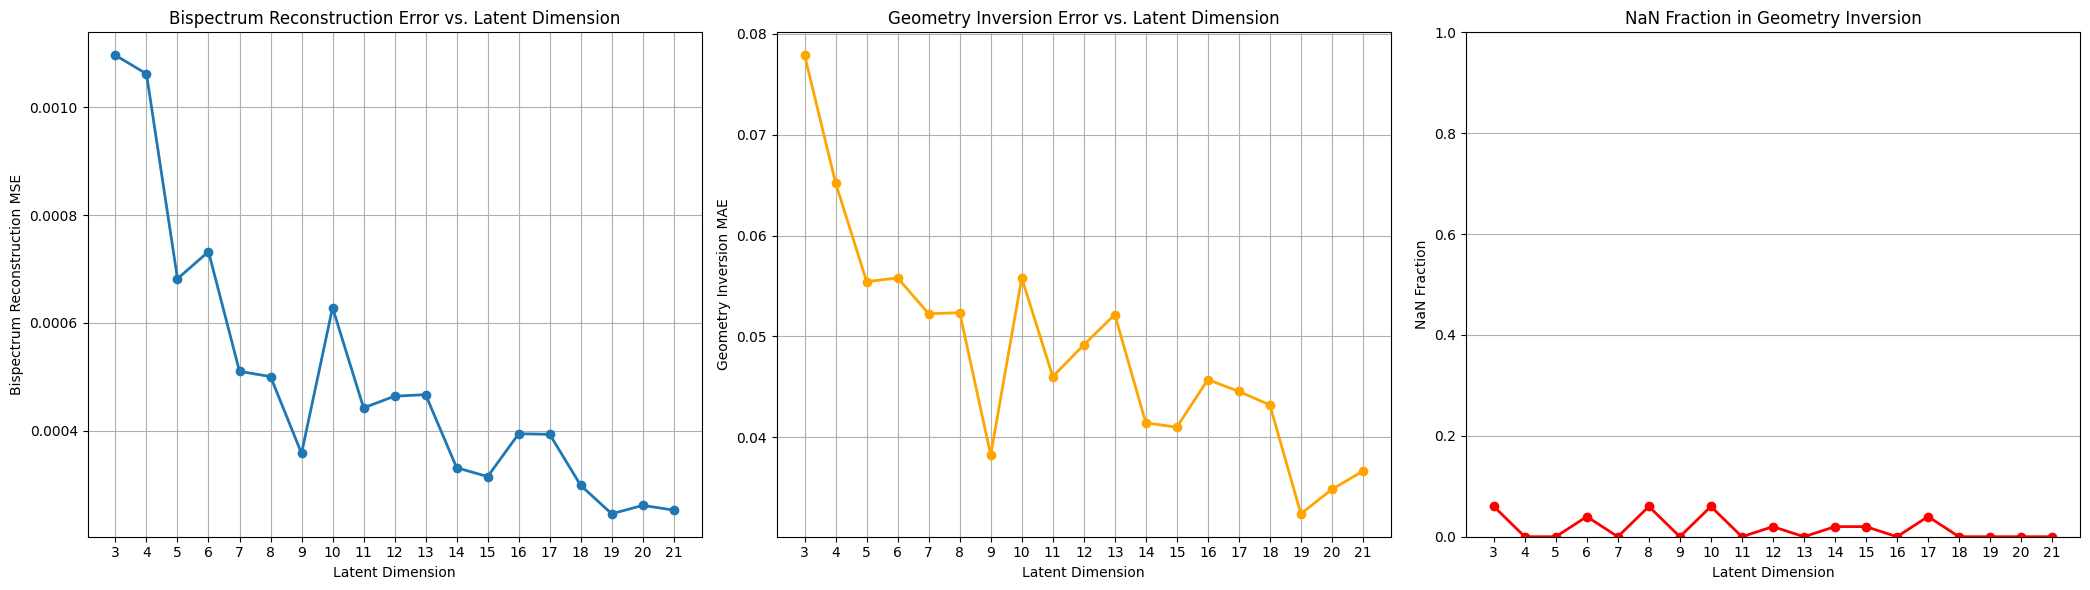

In [14]:
#--------------------------------------------------------------------------------
# Main Execution
#--------------------------------------------------------------------------------

if __name__ == "__main__":
    # Example of how to run the experiment with your 10,000 data points
    
    # Step 1: Load your bispectra and geometries

    bispectra = jnp.array(bispectra[:100000])
    geometries = local_envs[:100000]
        
    print(f"Loaded {len(bispectra)} bispectra with dimension {bispectra[0].shape}")
    print(f"Loaded {len(geometries)} geometries")
    
    # Step 2: Run the experiment with all latent dimensions from 2 to 14
    results = run_full_experiment(
        bispectra=bispectra,
        geometries=geometries,
        lmax=5,
        seed=42,
        latent_dims=range(3, 22)
        # latent_dims=range(20, 22)
    )
    
    # Step 3: Save the results
    with open("latent_dim_study_results_lmax5.pkl", "wb") as f:
        pickle.dump(results, f)
        
    # Step 4: Create a visualization of the optimal latent dimension
    plot_latent_study_results(results)

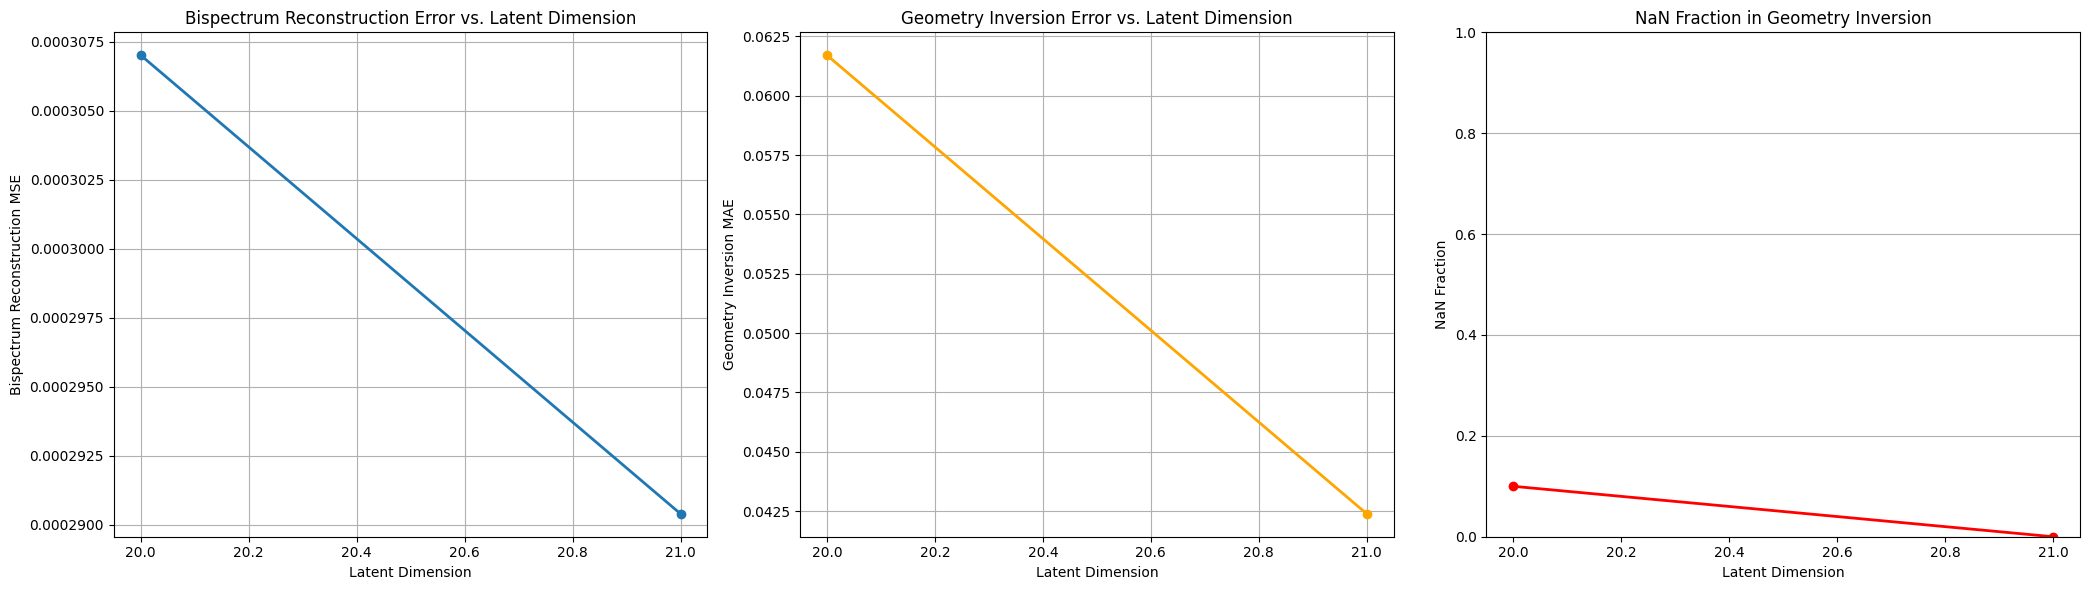

In [19]:
plot_latent_study_results(results)

In [11]:
results[]

[nan, nan]

In [8]:
# Load the model with latent dimension d
model_file = "autoencoder_latent20.pkl"
model, params = load_model(model_file)

# Select a sample bispectrum for testing
sample_idx = 0
sample_bispectrum = bispectra[sample_idx][None, :]

# Encode the sample to the latent space
latent_vector = model.apply(params, sample_bispectrum, method=model.encode)
print(f"Encoded shape: {latent_vector.shape}")

# Decode back to bispectrum space
reconstructed_bispectrum = model.apply(params, latent_vector, method=model.decode)
print(f"Reconstructed shape: {reconstructed_bispectrum.shape}")

# Calculate reconstruction error
reconstruction_error = jnp.mean((reconstructed_bispectrum - sample_bispectrum) ** 2)
print(f"Reconstruction MSE: {reconstruction_error:.6f}")

Model loaded from autoencoder_latent20.pkl
Encoded shape: (1, 20)
Reconstructed shape: (1, 22)
Reconstruction MSE: 0.000006


In [9]:
predicted_geometry, _, _ = invert(reconstructed_bispectrum, spectrum_function=bispectrum, lmax=5, n_points=10, learning_rate=1e-2, num_iterations=5000, patience=2000, mask_index=None, initial_points=None, seed=0)
print(f"Predicted geometry: {predicted_geometry}")

Predicted geometry: [[ 0.15348393 -0.39115532  1.08083737]
 [ 0.3950113  -0.40704579 -0.45928146]
 [-1.20218005 -0.09626237 -0.3147289 ]
 [ 0.38853182  1.18439915 -0.0808585 ]]


In [10]:
local_envs[sample_idx]

[(0.0149, -1.0918, -0.006),
 (1.0244, 0.3779999999999999, -0.0077),
 (-0.5280999999999999, 0.3616999999999999, -0.8846),
 (-0.5111, 0.35209999999999986, 0.8984)]

Model loaded from autoencoder_latent2.pkl
Latent dim 2: Avg MAE = 0.156371, NaN fraction = 0.64
Model loaded from autoencoder_latent4.pkl
Latent dim 4: Avg MAE = 0.155730, NaN fraction = 0.64
Model loaded from autoencoder_latent6.pkl
Latent dim 6: Avg MAE = 0.149108, NaN fraction = 0.64
Model loaded from autoencoder_latent8.pkl
Latent dim 8: Avg MAE = 0.148588, NaN fraction = 0.66
Model loaded from autoencoder_latent10.pkl
Latent dim 10: Avg MAE = 0.146592, NaN fraction = 0.64
Model loaded from autoencoder_latent12.pkl
Latent dim 12: Avg MAE = 0.155073, NaN fraction = 0.62
Model loaded from autoencoder_latent14.pkl
Latent dim 14: Avg MAE = 0.146507, NaN fraction = 0.66


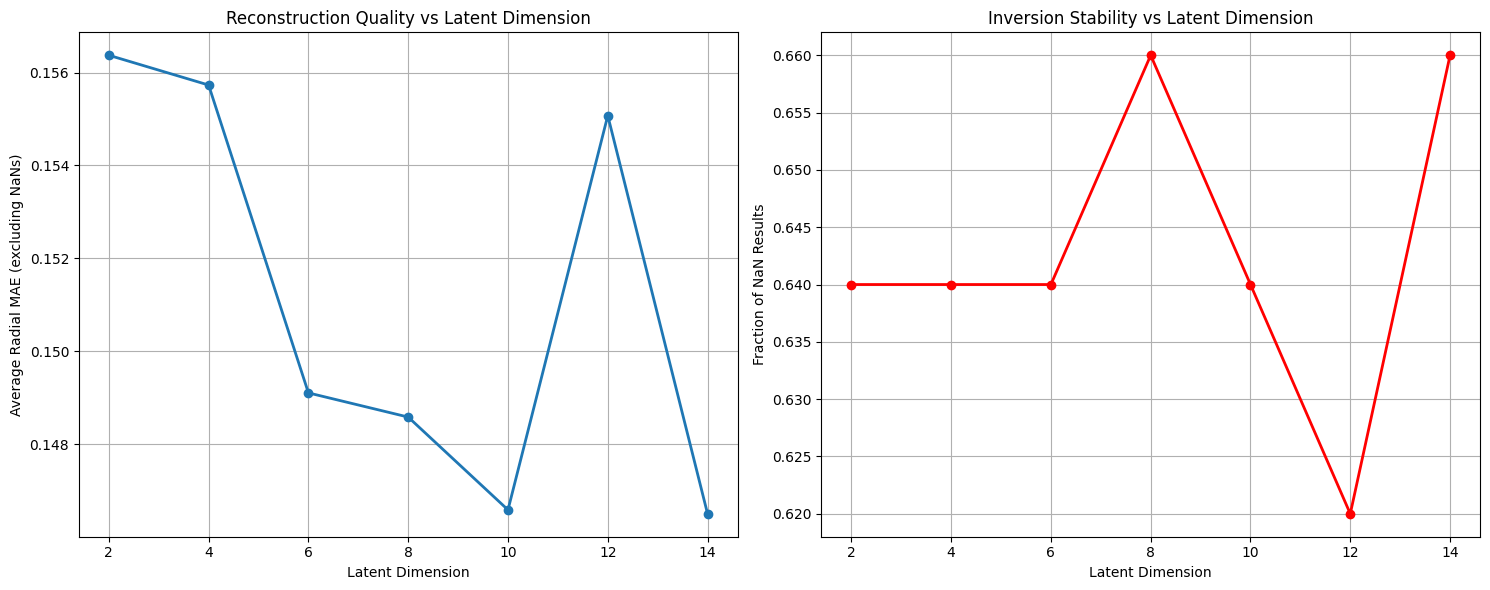

In [78]:
# Create a figure to compare performance across different latent dimensions
latent_dims = results['latent_dims']
avg_maes = []
nan_fractions = []

plt.figure(figsize=(15, 6))

# Split data into train/val/test sets once
seed = 42
_, _, test_bispectra = split_data(
    bispectra, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=seed
)

# Split geometries in the same way (using the same seed ensures the splits match)
_, _, test_geometries = split_data(
    local_envs, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=seed
)

# Test on the first 50 samples in the test set
num_samples = min(50, len(test_bispectra))

# Loop over all models with different latent dimensions
for latent_dim in latent_dims:
    # Load the model with the current latent dimension
    model_file = f"autoencoder_latent{latent_dim}.pkl"
    try:
        model, params = load_model(model_file)
        
        predicted_geometries = []
        radial_maes = []

        for sample_idx in range(num_samples):
            # Get the bispectrum for this sample from the test set
            sample_bispectrum = test_bispectra[sample_idx][None, :]
            
            # Encode the sample to the latent space
            latent_vector = model.apply(params, sample_bispectrum, method=model.encode)
            
            # Decode back to bispectrum space
            reconstructed_bispectrum = model.apply(params, latent_vector, method=model.decode)
            
            # Invert the reconstructed bispectrum to get the predicted geometry
            predicted_geometry, _, _ = invert(
                reconstructed_bispectrum, 
                spectrum_function=bispectrum, 
                lmax=4, 
                n_points=10, 
                learning_rate=1e-2, 
                num_iterations=10000, 
                patience=2000, 
                mask_index=None, 
                initial_points=None, 
                seed=0
            )
            
            # Calculate the radial MAE using the test geometries
            mae = radius_mae(test_geometries[sample_idx], predicted_geometry)
            
            # Store results
            predicted_geometries.append(predicted_geometry)
            radial_maes.append(mae)
        
        # Calculate statistics
        nan_count = np.sum(np.isnan(radial_maes))
        nan_fraction = nan_count / num_samples
        valid_maes = [mae for mae in radial_maes if not np.isnan(mae)]
        avg_mae = np.mean(valid_maes) if valid_maes else np.nan
        
        # Store results for plotting
        avg_maes.append(avg_mae)
        nan_fractions.append(nan_fraction)
        
        print(f"Latent dim {latent_dim}: Avg MAE = {avg_mae:.6f}, NaN fraction = {nan_fraction:.2f}")
    
    except Exception as e:
        print(f"Error processing latent dim {latent_dim}: {e}")
        avg_maes.append(np.nan)
        nan_fractions.append(np.nan)

# Create subplots
plt.subplot(1, 2, 1)
plt.plot(latent_dims, avg_maes, 'o-', linewidth=2)
plt.xlabel('Latent Dimension')
plt.ylabel('Average Radial MAE (excluding NaNs)')
plt.title('Reconstruction Quality vs Latent Dimension')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(latent_dims, nan_fractions, 'o-', linewidth=2, color='red')
plt.xlabel('Latent Dimension')
plt.ylabel('Fraction of NaN Results')
plt.title('Inversion Stability vs Latent Dimension')
plt.grid(True)

plt.tight_layout()
plt.show()

# Create a dictionary to store all results
inversion_comparison = {
    "latent_dims": latent_dims,
    "avg_maes": avg_maes,
    "nan_fractions": nan_fractions
}

Calculating baseline performance (direct inversion without autoencoder)...
Baseline (direct inversion): Avg MAE = 0.123944, NaN fraction = 0.64
Model loaded from autoencoder_latent2.pkl
Latent dim 2: Avg MAE = 0.156371, NaN fraction = 0.64
Model loaded from autoencoder_latent4.pkl
Latent dim 4: Avg MAE = 0.155730, NaN fraction = 0.64
Model loaded from autoencoder_latent6.pkl
Latent dim 6: Avg MAE = 0.149108, NaN fraction = 0.64
Model loaded from autoencoder_latent8.pkl
Latent dim 8: Avg MAE = 0.148588, NaN fraction = 0.66
Model loaded from autoencoder_latent10.pkl
Latent dim 10: Avg MAE = 0.146592, NaN fraction = 0.64
Model loaded from autoencoder_latent12.pkl
Latent dim 12: Avg MAE = 0.155073, NaN fraction = 0.62
Model loaded from autoencoder_latent14.pkl
Latent dim 14: Avg MAE = 0.146507, NaN fraction = 0.66


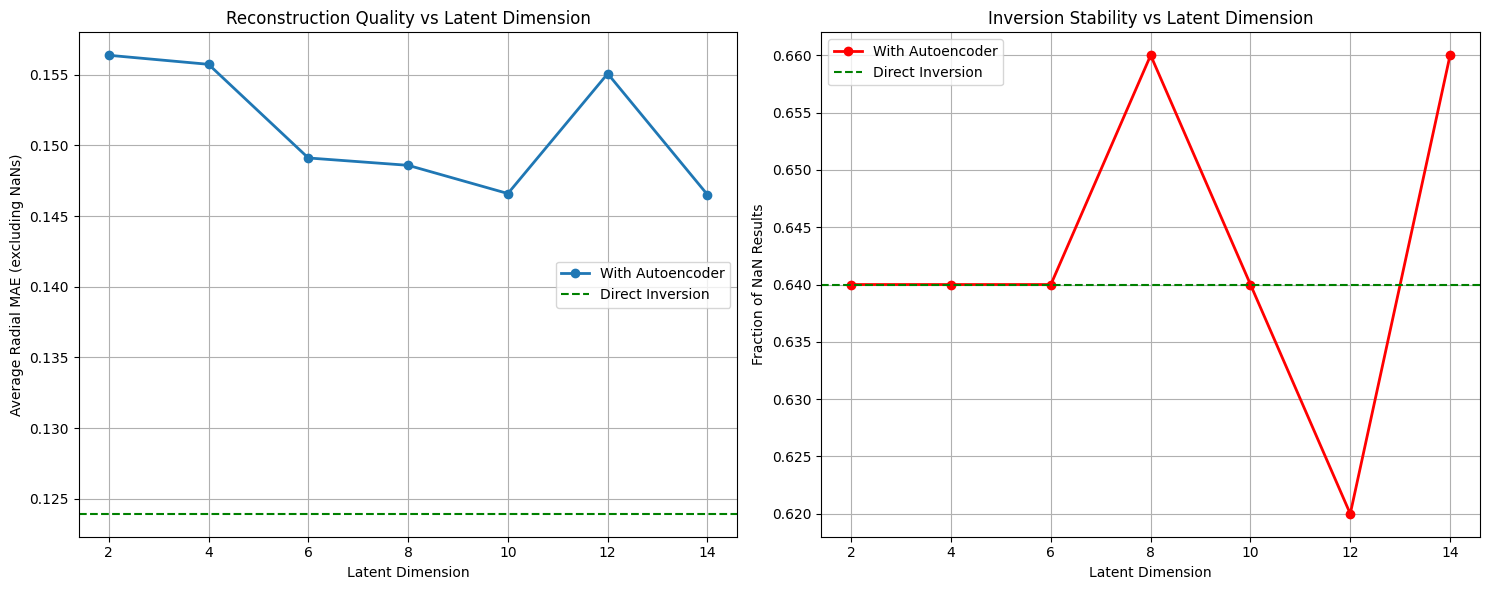

In [79]:
# Create a figure to compare performance across different latent dimensions
latent_dims = results['latent_dims']
reconstruction_errors = []
inversion_errors = []
nan_fractions = []

plt.figure(figsize=(15, 6))

# Split data into train/val/test sets once
seed = 42
_, _, test_bispectra = split_data(
    bispectra, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=seed
)

# Split geometries in the same way (using the same seed ensures the splits match)
_, _, test_geometries = split_data(
    local_envs, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=seed
)

# Test on the first 50 samples in the test set
num_samples = min(50, len(test_bispectra))

# First, calculate baseline performance by directly inverting the original bispectra
baseline_radial_maes = []
print("Calculating baseline performance (direct inversion without autoencoder)...")

for sample_idx in range(num_samples):
    # Get the bispectrum for this sample from the test set
    sample_bispectrum = test_bispectra[sample_idx][None, :]
    
    # Directly invert the original bispectrum
    predicted_geometry, _, _ = invert(
        sample_bispectrum, 
        spectrum_function=bispectrum, 
        lmax=4, 
        n_points=10, 
        learning_rate=1e-2, 
        num_iterations=10000, 
        patience=2000, 
        mask_index=None, 
        initial_points=None, 
        seed=0
    )
    
    # Calculate the radial MAE using the test geometries
    mae = radius_mae(test_geometries[sample_idx], predicted_geometry)
    baseline_radial_maes.append(mae)

# Calculate baseline statistics
baseline_nan_count = np.sum(np.isnan(baseline_radial_maes))
baseline_nan_fraction = baseline_nan_count / num_samples
baseline_valid_maes = [mae for mae in baseline_radial_maes if not np.isnan(mae)]
baseline_avg_mae = np.mean(baseline_valid_maes) if baseline_valid_maes else np.nan

print(f"Baseline (direct inversion): Avg MAE = {baseline_avg_mae:.6f}, NaN fraction = {baseline_nan_fraction:.2f}")

# Loop over all models with different latent dimensions
for latent_dim in latent_dims:
    # Load the model with the current latent dimension
    model_file = f"autoencoder_latent{latent_dim}.pkl"
    try:
        model, params = load_model(model_file)
        
        predicted_geometries = []
        radial_maes = []

        for sample_idx in range(num_samples):
            # Get the bispectrum for this sample from the test set
            sample_bispectrum = test_bispectra[sample_idx][None, :]
            
            # Encode the sample to the latent space
            latent_vector = model.apply(params, sample_bispectrum, method=model.encode)
            
            # Decode back to bispectrum space
            reconstructed_bispectrum = model.apply(params, latent_vector, method=model.decode)
            
            # Invert the reconstructed bispectrum to get the predicted geometry
            predicted_geometry, _, _ = invert(
                reconstructed_bispectrum, 
                spectrum_function=bispectrum, 
                lmax=4, 
                n_points=10, 
                learning_rate=1e-2, 
                num_iterations=10000, 
                patience=2000, 
                mask_index=None, 
                initial_points=None, 
                seed=0
            )
            
            # Calculate the radial MAE using the test geometries
            mae = radius_mae(test_geometries[sample_idx], predicted_geometry)
            
            # Store results
            predicted_geometries.append(predicted_geometry)
            radial_maes.append(mae)
        
        # Calculate statistics
        nan_count = np.sum(np.isnan(radial_maes))
        nan_fraction = nan_count / num_samples
        valid_maes = [mae for mae in radial_maes if not np.isnan(mae)]
        avg_mae = np.mean(valid_maes) if valid_maes else np.nan
        
        # Store results for plotting
        inversion_errors.append(avg_mae)
        nan_fractions.append(nan_fraction)
        
        print(f"Latent dim {latent_dim}: Avg MAE = {avg_mae:.6f}, NaN fraction = {nan_fraction:.2f}")
    
    except Exception as e:
        print(f"Error processing latent dim {latent_dim}: {e}")
        inversion_errors.append(np.nan)
        nan_fractions.append(np.nan)

# Create subplots
plt.subplot(1, 2, 1)
plt.plot(latent_dims, inversion_errors, 'o-', linewidth=2, label='With Autoencoder')
plt.axhline(y=baseline_avg_mae, color='g', linestyle='--', label='Direct Inversion')
plt.xlabel('Latent Dimension')
plt.ylabel('Average Radial MAE (excluding NaNs)')
plt.title('Reconstruction Quality vs Latent Dimension')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(latent_dims, nan_fractions, 'o-', linewidth=2, color='red', label='With Autoencoder')
plt.axhline(y=baseline_nan_fraction, color='g', linestyle='--', label='Direct Inversion')
plt.xlabel('Latent Dimension')
plt.ylabel('Fraction of NaN Results')
plt.title('Inversion Stability vs Latent Dimension')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Create a dictionary to store all results
inversion_comparison = {
    "latent_dims": latent_dims,
    "inversion_errors": inversion_errors,
    "nan_fractions": nan_fractions,
    "baseline_avg_mae": baseline_avg_mae,
    "baseline_nan_fraction": baseline_nan_fraction
}

In [81]:
# First, calculate baseline performance by directly inverting the original bispectra

predicted_geometries = []

for sample_idx in range(num_samples):
    # Get the bispectrum for this sample from the test set
    sample_bispectrum = test_bispectra[sample_idx][None, :]
    
    # Directly invert the original bispectrum
    predicted_geometry, _, _ = invert(
        sample_bispectrum, 
        spectrum_function=bispectrum, 
        lmax=4, 
        n_points=10, 
        learning_rate=1e-2, 
        num_iterations=10000, 
        patience=2000, 
        mask_index=None, 
        initial_points=None, 
        seed=0
    )
    
    predicted_geometries.append(predicted_geometry)

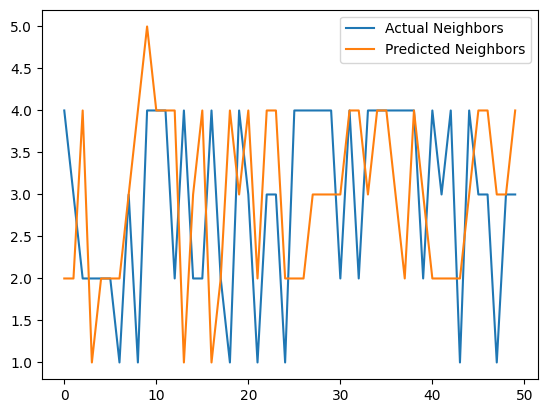

In [82]:
num_actual_neighbors = [len(local_envs[i]) for i in range(len(local_envs[:50]))]
num_predicted_neighbors = [len(predicted_geometries[i]) for i in range(len(predicted_geometries[:50]))]

plt.plot(num_actual_neighbors, label='Actual Neighbors')
plt.plot(num_predicted_neighbors, label='Predicted Neighbors')
plt.legend()

In [83]:
lmax = 5
bispectra_lmax5 = []
for local_env in tqdm(local_envs[:50]):
    true_geometry = jnp.array(local_env)
    true_signal = sum_of_diracs(true_geometry, lmax)
    true_bispectrum = bispectrum(true_signal)
    bispectra_lmax5.append(true_bispectrum)

100%|██████████| 50/50 [00:04<00:00, 10.08it/s]


In [86]:
# First, calculate baseline performance by directly inverting the original bispectra

predicted_geometries = []

for sample_idx in tqdm(range(num_samples)):
    # Get the bispectrum for this sample from the test set
    sample_bispectrum = bispectra_lmax5[sample_idx][None, :]
    
    # Directly invert the original bispectrum
    predicted_geometry, _, _ = invert(
        sample_bispectrum, 
        spectrum_function=bispectrum, 
        lmax=5, 
        n_points=10, 
        learning_rate=1e-2, 
        num_iterations=10000, 
        patience=2000, 
        mask_index=None, 
        initial_points=None, 
        seed=0
    )
    
    predicted_geometries.append(predicted_geometry)

100%|██████████| 50/50 [02:00<00:00,  2.42s/it]


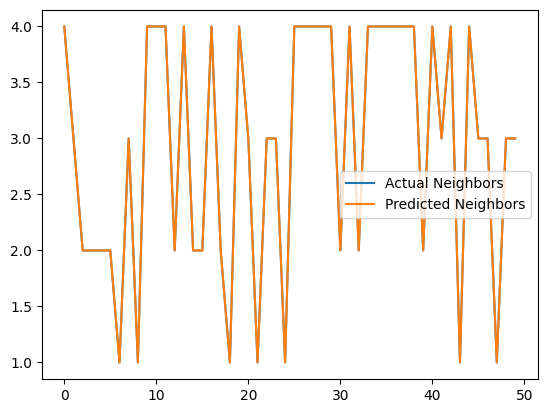

In [87]:
num_actual_neighbors = [len(local_envs[i]) for i in range(len(local_envs[:50]))]
num_predicted_neighbors = [len(predicted_geometries[i]) for i in range(len(predicted_geometries[:50]))]

plt.plot(num_actual_neighbors, label='Actual Neighbors')
plt.plot(num_predicted_neighbors, label='Predicted Neighbors')
plt.legend()

In [15]:
def invert_via_encoder(model, params, target_latent, lmax, spectrum_function=bispectrum, 
                      n_points=20, learning_rate=1e-2, num_iterations=10000, patience=2000,
                      mask_index=None, initial_points=None, seed=0):
    """
    Inverts a latent vector to 3D points by directly optimizing in the latent space.
    
    Args:
        model: Trained autoencoder model
        params: Trained parameters
        target_latent: Target latent vector to invert
        lmax: Maximum degree for spherical harmonics
        spectrum_function: Function to compute the spectrum (default: bispectrum)
        n_points: Number of points to generate
        learning_rate: Learning rate for inversion
        num_iterations: Maximum number of iterations
        patience: Patience for early stopping
        mask_index: Index of the spectrum component to mask in loss calculation
        initial_points: Initial point locations (None for random initialization)
        seed: Random seed for initialization
        
    Returns:
        3D points representing the geometry, points history, and losses history
    """
    def loss(params_inversion, target_latent):
        """Computes the loss in latent space."""
        # Compute bispectrum of current points
        predicted_signal = sum_of_diracs(params_inversion["points"], lmax)
        current_bispectrum = spectrum_function(predicted_signal)
        
        # Encode the bispectrum to get the latent vector
        current_latent = model.apply(params, current_bispectrum[None, :], method=model.encode)[0]
        
        # Compute the loss as the distance in latent space
        return jnp.mean((target_latent - current_latent) ** 2)
    
    def fit(params_inversion, learning_rate, target_latent, max_iter=num_iterations):
        """Optimization function for finding the geometry."""
        # Create optimizer with fixed learning rate
        optimizer = optax.adam(learning_rate=learning_rate)        
        opt_state = optimizer.init(params_inversion)
        
        # Track optimization progress
        min_loss = float('inf')
        no_improvement_count = 0
        
        # Save best parameters
        best_params = jax.tree_util.tree_map(lambda x: x.copy(), params_inversion)
        
        # Initialize points history dictionary
        points_history = {}
        losses_history = {}
        
        # Pure function to update parameters - JIT compatible
        @jax.jit
        def step(params_inversion, opt_state, target_latent):
            loss_value, grads = jax.value_and_grad(loss)(
                params_inversion, target_latent
            )
            updates, opt_state = optimizer.update(grads, opt_state, params_inversion)
            params_inversion = optax.apply_updates(params_inversion, updates)
            return params_inversion, opt_state, loss_value
        
        for iter in range(max_iter):
            # Update parameters
            params_inversion, opt_state, loss_value = step(
                params_inversion, opt_state, target_latent
            )
            
            # Save points every 100 iterations
            if iter % 100 == 0:
                points_history[iter] = jax.device_get(params_inversion["points"])
                losses_history[iter] = jax.device_get(loss_value)
                # Uncomment for debugging
                # print(f"step {iter}, loss: {loss_value}")
            
            # Check if loss decreased
            if loss_value < min_loss:
                min_loss = loss_value
                no_improvement_count = 0
                # Save the best parameters
                best_params = jax.tree_util.tree_map(lambda x: x.copy(), params_inversion)
            else:
                no_improvement_count += 1
                
            # Early stopping if no improvement for patience iterations
            if no_improvement_count >= patience:
                # Uncomment for debugging
                # print(f"Stopping early at step {iter}: no improvement for {patience} iterations")
                # Save the final points before breaking
                if iter % 100 != 0:  # Only if we haven't just saved them
                    points_history[iter] = jax.device_get(params_inversion["points"])
                    losses_history[iter] = jax.device_get(loss_value)
                break

        # Return the best parameters found during optimization
        # print(f"Final best loss: {min_loss}")
        return best_params, points_history, losses_history
    
    # Initialize points if not provided
    if initial_points is None and n_points is None:
        rng = jax.random.PRNGKey(seed)
        initial_points = dodecahedron + 0.1 * jax.random.normal(rng, (dodecahedron.shape[0], 3))
    elif initial_points is None and n_points is not None:
        rng = jax.random.PRNGKey(seed)
        initial_points = jax.random.normal(rng, (n_points, 3))
    init_params = {"points": initial_points}
    
    # Run optimization
    final_params, points_history, losses_history = fit(init_params, learning_rate, target_latent)
    
    predicted_points = final_params["points"]
    predicted_geometry = stack_points(predicted_points)
    
    return predicted_geometry, points_history, losses_history

In [33]:
def multi_stage_encoder_inversion(model, params, target_latent, lmax, n_points=10):
    """
    Performs multi-stage inversion of a latent embedding with different learning rates.
    
    Args:
        model: Trained autoencoder model
        params: Trained parameters
        target_latent: Target latent vector to invert
        lmax: Maximum degree for spherical harmonics
        n_points: Number of points to use for initial inversion
        
    Returns:
        jnp.ndarray: The predicted geometry with the lowest loss
    """
    # Define a list of learning rates to use in sequence
    learning_rates = [1e-2, 1e-3]
    
    # Run the initial inversion
    predicted_points, _, losses_history = invert_via_encoder(
        model, params, target_latent, lmax, 
        n_points=n_points, learning_rate=learning_rates[0], 
        patience=10000
    )
    
    # Stack points after first inversion
    stacked_points = stack_points(predicted_points)
    current_points = stacked_points
    
    # Track the best points and lowest loss
    best_loss = float('inf')
    best_points = None
    
    # Store the initial result if it's the best so far
    min_loss_key = min(losses_history, key=losses_history.get)
    if losses_history[min_loss_key] < best_loss:
        best_loss = losses_history[min_loss_key]
        best_points = predicted_points
    
    # Run subsequent inversion with different learning rate
    predicted_points, _, losses_history = invert_via_encoder(
        model, params, target_latent, lmax, 
        initial_points=current_points, learning_rate=learning_rates[1], 
        patience=10000
    )
    current_points = predicted_points
    
    # Check if this phase produced a better result
    min_loss_key = min(losses_history, key=losses_history.get)
    if losses_history[min_loss_key] < best_loss:
        best_loss = losses_history[min_loss_key]
        best_points = predicted_points
    
    return best_points

In [25]:
# Load your trained model
model, params = load_model("autoencoder_latent3.pkl")  # Adjust with your model file

# For a given bispectrum that you want to invert
bispectrum_vector = bispectra[0]  # Example bispectrum

# First encode it to get the latent representation
latent = model.apply(params, bispectrum_vector[None, :], method=model.encode)[0]

# Then invert using the encoder-based approach
reconstructed_geometry = multi_stage_encoder_inversion(
    model, params, latent, lmax=5, n_points=10
)

reconstructed_geometry = jnp.array(reconstructed_geometry)
original_geometry = jnp.array(geometries[0])

# Visualize the original and reconstructed geometries
compare_geometries(original_geometry, "original", reconstructed_geometry, "reconstructed")

Model loaded from autoencoder_latent3.pkl


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'name': 'Signal',
              'scene': 'scene',
              'showlegend': True,
              'showscale': False,
              'surfacecolor': {'bdata': ('I74mQ5shEUAjviZDmyERQCO+JkObIR' ... 'Z1diRV+T/SZnV2JFX5P9JmdXYkVfk/'),
                               'dtype': 'f8',
                               'shape': '102, 100'},
              'type': 'surface',
              'x': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAIAAAAAAAAAAgAAAAAAAAAAA'),
                    'dtype': 'f8',
                    'shape': '102, 100'},
              'y': {'bdata': ('JzRl71jo778nNGXvWOjvvyc0Ze9Y6O' ... 's6WmeX1z86uzpaZ5fXPzq7Olpnl9c/'),
                    'dtype': 'f8',
                    'shape': '102, 100'},
              'z': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8',
                    'shape': '102, 100'}},
             {'name': 'Signal',
              'scene': 'scene2',
              'showlegend': True,
              'showscale': False,
              'surfacecolor': {'bdata': ('Q3ac8wAn6j9DdpzzACfqP0N2nPMAJ+' ... 'fuDqFaCUCkl+4OoVoJQKSX7g6hWglA'),
                               'dtype': 'f8',
                               'shape': '102, 100'},
              'type': 'surface',
              'x': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAIAAAAAAAAAAgAAAAAAAAAAA'),
                    'dtype': 'f8',
                    'shape': '102, 100'},
              'y': {'bdata': ('vMEhKMMfyL+8wSEowx/Iv7zBISjDH8' ... 'KNAz1j5z8NEo0DPWPnPw0SjQM9Y+c/'),
                    'dtype': 'f8',
                    'shape': '102, 100'},
              'z': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8',
                    'shape': '102, 100'}}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'original',
                                'x': 0.225,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'reconstructed',
                                'x': 0.775,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'margin': {'b': 0, 'l': 0, 'r': 0, 't': 30},
               'paper_bgcolor': 'rgba(255,255,255,255)',
               'plot_bgcolor': 'rgba(255,255,255,255)',
               'scene': {'aspectmode': 'cube',
                         'bgcolor': 'rgba(255,255,255,255)',
                         'camera': {'eye': {'x': 0.3, 'y': 0.3, 'z': 0.3}},
                         'domain': {'x': [0.0, 0.45], 'y': [0.0, 1.0]},
                         'xaxis': {'backgroundcolor': 'rgba(255,255,255,255)',
                                   'range': [-2.5, 2.5],
                                   'showgrid': False,
                                   'showticklabels': False,
                                   'title': {'text': ''},
                                   'zeroline': False},
                         'yaxis': {'backgroundcolor': 'rgba(255,255,255,255)',
                                   'range': [-2.5, 2.5],
                                   'showgrid': False,
                                   'showticklabels': False,
                                   'title': {'text': ''},
                                   'zeroline': False},
                         'zaxis': {'backgroundcolor': 'rgba(255,255,255,255)',
                     

In [26]:
radius_mae(original_geometry, reconstructed_geometry)

0.011127658012203057

In [58]:
maes_invert_via_encoder = {i: [] for i in range(3, 22)}

for latent_dim in range(3, 22):

    # Load your trained model
    model, params = load_model(f"autoencoder_latent{latent_dim}.pkl")  # Adjust with your model file

    for i in tqdm(range(50)):

        # For a given bispectrum that you want to invert
        bispectrum_vector = bispectra[i]

        # First encode it to get the latent representation
        latent = model.apply(params, bispectrum_vector[None, :], method=model.encode)[0]
        
        # Then invert the latent vector to get the geometry
        reconstructed_geometry = multi_stage_encoder_inversion(
            model, params, latent, lmax=5, n_points=10
        )
        reconstructed_geometry = jnp.array(reconstructed_geometry)
        original_geometry = jnp.array(geometries[i]) 

        maes_invert_via_encoder[latent_dim].append(radius_mae(original_geometry, reconstructed_geometry))

Model loaded from autoencoder_latent3.pkl


100%|██████████| 50/50 [08:12<00:00,  9.85s/it]


Model loaded from autoencoder_latent4.pkl


100%|██████████| 50/50 [23:38<00:00, 28.38s/it] 


Model loaded from autoencoder_latent5.pkl


100%|██████████| 50/50 [1:16:43<00:00, 92.08s/it] 


Model loaded from autoencoder_latent6.pkl


100%|██████████| 50/50 [1:04:31<00:00, 77.44s/it] 


Model loaded from autoencoder_latent7.pkl


100%|██████████| 50/50 [27:55<00:00, 33.51s/it]   


Model loaded from autoencoder_latent8.pkl


100%|██████████| 50/50 [22:28<00:00, 26.98s/it]   


Model loaded from autoencoder_latent9.pkl


100%|██████████| 50/50 [06:53<00:00,  8.27s/it]


Model loaded from autoencoder_latent10.pkl


100%|██████████| 50/50 [07:00<00:00,  8.41s/it]


Model loaded from autoencoder_latent11.pkl


100%|██████████| 50/50 [07:01<00:00,  8.43s/it]


Model loaded from autoencoder_latent12.pkl


100%|██████████| 50/50 [07:00<00:00,  8.41s/it]


Model loaded from autoencoder_latent13.pkl


100%|██████████| 50/50 [07:01<00:00,  8.43s/it]


Model loaded from autoencoder_latent14.pkl


100%|██████████| 50/50 [06:59<00:00,  8.39s/it]


Model loaded from autoencoder_latent15.pkl


100%|██████████| 50/50 [07:03<00:00,  8.48s/it]


Model loaded from autoencoder_latent16.pkl


100%|██████████| 50/50 [07:02<00:00,  8.44s/it]


Model loaded from autoencoder_latent17.pkl


100%|██████████| 50/50 [07:00<00:00,  8.40s/it]


Model loaded from autoencoder_latent18.pkl


100%|██████████| 50/50 [06:59<00:00,  8.39s/it]


Model loaded from autoencoder_latent19.pkl


100%|██████████| 50/50 [07:02<00:00,  8.45s/it]


Model loaded from autoencoder_latent20.pkl


100%|██████████| 50/50 [54:56<00:00, 65.92s/it]   


Model loaded from autoencoder_latent21.pkl


100%|██████████| 50/50 [13:28<00:00, 16.16s/it] 


In [59]:
maes_decode_invert_via_encoder = {i: [] for i in range(3, 22)}

for latent_dim in range(3, 22):

    # Load your trained model
    model, params = load_model(f"autoencoder_latent{latent_dim}.pkl")  # Adjust with your model file

    for i in tqdm(range(50)):

        # For a given bispectrum that you want to invert
        bispectrum_vector = bispectra[i]

        # First encode it to get the latent representation
        latent = model.apply(params, bispectrum_vector[None, :], method=model.encode)[0]
        
        # Pass the latent through the decoder to get a reconstructed bispectrum
        reconstructed_bispectrum = model.apply(params, latent[None, :], method=model.decode)[0]
        
        # Invert the reconstructed bispectrum to get initial points
        initial_points = multi_stage_inversion(
            reconstructed_bispectrum, lmax=5, n_points=10
        )
        
        # Then invert using the encoder-based approach with the initial points
        reconstructed_geometry, _, _ = invert_via_encoder(
            model, params, latent, lmax=5, initial_points=initial_points
        )

        reconstructed_geometry = jnp.array(reconstructed_geometry)
        original_geometry = jnp.array(geometries[i]) 

        maes_decode_invert_via_encoder[latent_dim].append(radius_mae(original_geometry, reconstructed_geometry))

Model loaded from autoencoder_latent3.pkl


100%|██████████| 50/50 [12:32<00:00, 15.05s/it]


Model loaded from autoencoder_latent4.pkl


100%|██████████| 50/50 [25:27<00:00, 30.56s/it]   


Model loaded from autoencoder_latent5.pkl


100%|██████████| 50/50 [11:33<00:00, 13.87s/it]


Model loaded from autoencoder_latent6.pkl


100%|██████████| 50/50 [12:18<00:00, 14.78s/it]


Model loaded from autoencoder_latent7.pkl


100%|██████████| 50/50 [12:19<00:00, 14.79s/it]


Model loaded from autoencoder_latent8.pkl


100%|██████████| 50/50 [12:25<00:00, 14.92s/it]


Model loaded from autoencoder_latent9.pkl


100%|██████████| 50/50 [21:45<00:00, 26.11s/it] 


Model loaded from autoencoder_latent10.pkl


100%|██████████| 50/50 [46:57<00:00, 56.35s/it] 


Model loaded from autoencoder_latent11.pkl


100%|██████████| 50/50 [14:53<00:00, 17.86s/it]


Model loaded from autoencoder_latent12.pkl


100%|██████████| 50/50 [13:07<00:00, 15.76s/it]


Model loaded from autoencoder_latent13.pkl


100%|██████████| 50/50 [21:30<00:00, 25.80s/it] 


Model loaded from autoencoder_latent14.pkl


100%|██████████| 50/50 [09:34<00:00, 11.49s/it]


Model loaded from autoencoder_latent15.pkl


100%|██████████| 50/50 [09:46<00:00, 11.73s/it]


Model loaded from autoencoder_latent16.pkl


100%|██████████| 50/50 [09:58<00:00, 11.97s/it]


Model loaded from autoencoder_latent17.pkl


100%|██████████| 50/50 [09:47<00:00, 11.74s/it]


Model loaded from autoencoder_latent18.pkl


100%|██████████| 50/50 [09:53<00:00, 11.88s/it]


Model loaded from autoencoder_latent19.pkl


100%|██████████| 50/50 [09:12<00:00, 11.06s/it]


Model loaded from autoencoder_latent20.pkl


100%|██████████| 50/50 [10:27<00:00, 12.55s/it]


Model loaded from autoencoder_latent21.pkl


100%|██████████| 50/50 [10:37<00:00, 12.76s/it]


In [60]:
maes_invert_via_encoder = {i: [] for i in range(3, 22)}

for latent_dim in range(3, 22):

    # Load your trained model
    model, params = load_model(f"autoencoder_latent{latent_dim}.pkl")  # Adjust with your model file

    for i in tqdm(range(50)):

        # For a given bispectrum that you want to invert
        bispectrum_vector = bispectra[i]

        # First encode it to get the latent representation
        latent = model.apply(params, bispectrum_vector[None, :], method=model.encode)[0]
        
        # Pass the latent through the decoder to get a reconstructed bispectrum
        reconstructed_bispectrum = model.apply(params, latent[None, :], method=model.decode)[0]
        
        # Invert the reconstructed bispectrum to get initial points
        reconstructed_geometry = multi_stage_encoder_inversion(
            model, params, latent, lmax=5, n_points=10
        )
        
        reconstructed_geometry = jnp.array(reconstructed_geometry)
        original_geometry = jnp.array(geometries[i]) 

        maes_invert_via_encoder[latent_dim].append(radius_mae(original_geometry, reconstructed_geometry))

Model loaded from autoencoder_latent3.pkl


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [08:40<00:00, 10.40s/it]


Model loaded from autoencoder_latent4.pkl


100%|██████████| 50/50 [08:23<00:00, 10.06s/it]


Model loaded from autoencoder_latent5.pkl


100%|██████████| 50/50 [08:37<00:00, 10.34s/it]


Model loaded from autoencoder_latent6.pkl


100%|██████████| 50/50 [08:17<00:00,  9.96s/it]


Model loaded from autoencoder_latent7.pkl


100%|██████████| 50/50 [08:21<00:00, 10.03s/it]


Model loaded from autoencoder_latent8.pkl


100%|██████████| 50/50 [08:12<00:00,  9.86s/it]


Model loaded from autoencoder_latent9.pkl


100%|██████████| 50/50 [07:55<00:00,  9.50s/it]


Model loaded from autoencoder_latent10.pkl


100%|██████████| 50/50 [07:31<00:00,  9.04s/it]


Model loaded from autoencoder_latent11.pkl


100%|██████████| 50/50 [07:52<00:00,  9.46s/it]


Model loaded from autoencoder_latent12.pkl


100%|██████████| 50/50 [08:03<00:00,  9.67s/it]


Model loaded from autoencoder_latent13.pkl


100%|██████████| 50/50 [08:19<00:00,  9.99s/it]


Model loaded from autoencoder_latent14.pkl


100%|██████████| 50/50 [07:44<00:00,  9.29s/it]


Model loaded from autoencoder_latent15.pkl


100%|██████████| 50/50 [07:52<00:00,  9.45s/it]


Model loaded from autoencoder_latent16.pkl


100%|██████████| 50/50 [07:45<00:00,  9.32s/it]


Model loaded from autoencoder_latent17.pkl


100%|██████████| 50/50 [07:31<00:00,  9.02s/it]


Model loaded from autoencoder_latent18.pkl


100%|██████████| 50/50 [07:44<00:00,  9.30s/it]


Model loaded from autoencoder_latent19.pkl


100%|██████████| 50/50 [07:48<00:00,  9.38s/it]


Model loaded from autoencoder_latent20.pkl


100%|██████████| 50/50 [31:02<00:00, 37.24s/it]   


Model loaded from autoencoder_latent21.pkl


100%|██████████| 50/50 [12:05<00:00, 14.51s/it]


In [62]:
# Save the MAE dictionary to a file
import pickle

# Save the dictionary to a file
with open('maes_decode_invert_via_encoder.pkl', 'wb') as f:
    pickle.dump(maes_decode_invert_via_encoder, f)

print("MAE dictionary has been saved successfully.")


MAE dictionary has been saved successfully.


Latent dim 3: Avg MAE = 0.034010, NaN fraction = 0.04
Latent dim 4: Avg MAE = 0.031021, NaN fraction = 0.04
Latent dim 5: Avg MAE = 0.030211, NaN fraction = 0.00
Latent dim 6: Avg MAE = 0.021603, NaN fraction = 0.04
Latent dim 7: Avg MAE = 0.007308, NaN fraction = 0.00
Latent dim 8: Avg MAE = 0.010274, NaN fraction = 0.00
Latent dim 9: Avg MAE = 0.004756, NaN fraction = 0.00
Latent dim 10: Avg MAE = 0.015219, NaN fraction = 0.02
Latent dim 11: Avg MAE = 0.006025, NaN fraction = 0.00
Latent dim 12: Avg MAE = 0.006393, NaN fraction = 0.02
Latent dim 13: Avg MAE = 0.005227, NaN fraction = 0.00
Latent dim 14: Avg MAE = 0.009818, NaN fraction = 0.02
Latent dim 15: Avg MAE = 0.004929, NaN fraction = 0.00
Latent dim 16: Avg MAE = 0.008587, NaN fraction = 0.02
Latent dim 17: Avg MAE = 0.006941, NaN fraction = 0.00
Latent dim 18: Avg MAE = 0.005237, NaN fraction = 0.00
Latent dim 19: Avg MAE = 0.006927, NaN fraction = 0.00
Latent dim 20: Avg MAE = 0.005341, NaN fraction = 0.00
Latent dim 21: Av

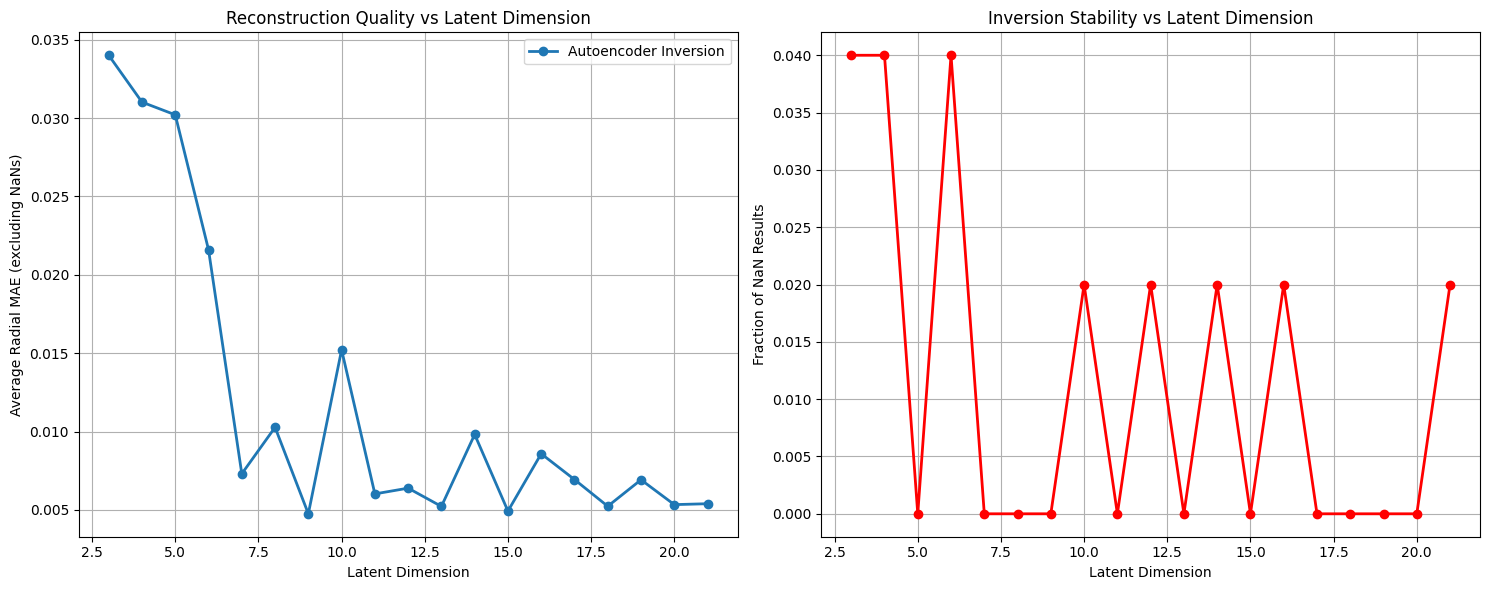

In [63]:
# Create a figure to compare performance across different latent dimensions
latent_dims = list(range(3, 22))
inversion_errors = []
nan_fractions = []

plt.figure(figsize=(15, 6))

# Calculate statistics for each latent dimension
for latent_dim in latent_dims:
    # Get the MAEs for this latent dimension
    maes = maes_decode_invert_via_encoder[latent_dim]
    
    # Calculate statistics
    nan_count = np.sum(np.isnan(maes))
    nan_fraction = nan_count / len(maes)
    valid_maes = [mae for mae in maes if not np.isnan(mae)]
    avg_mae = np.mean(valid_maes) if valid_maes else np.nan
    
    # Store results for plotting
    inversion_errors.append(avg_mae)
    nan_fractions.append(nan_fraction)
    
    print(f"Latent dim {latent_dim}: Avg MAE = {avg_mae:.6f}, NaN fraction = {nan_fraction:.2f}")

# Create subplots
plt.subplot(1, 2, 1)
plt.plot(latent_dims, inversion_errors, 'o-', linewidth=2, label='Autoencoder Inversion')
plt.xlabel('Latent Dimension')
plt.ylabel('Average Radial MAE (excluding NaNs)')
plt.title('Reconstruction Quality vs Latent Dimension')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(latent_dims, nan_fractions, 'o-', linewidth=2, color='red')
plt.xlabel('Latent Dimension')
plt.ylabel('Fraction of NaN Results')
plt.title('Inversion Stability vs Latent Dimension')
plt.grid(True)

plt.tight_layout()
plt.show()

# Create a dictionary to store all results
inversion_comparison = {
    "latent_dims": latent_dims,
    "inversion_errors": inversion_errors,
    "nan_fractions": nan_fractions
}
